<div>
    <h1 style="float: left;">Guide d'utilisation</h1>
    <img style="width:20%; height: auto;" src="img/CelesteLogo.png">
</div>

<p>
    Celeste est un jeu de type "die and retry" où il faut se déplacer parmi de multiples obstacles afin d'arriver à la fin du niveau pour passer au suivant.
    La version GBA de Celeste est une version simplifiée se basant sur la machine virtuelle PICO-8 comptant 30 niveaux.
</p>

<p>
    Notre objectif était de développer une IA pouvant jouer au jeu d'elle-même en essayant de s'améliorer au fil des essais.
    Pour cela nous avons utilisé Gym-Retro, une bibliothèque d'Open IA se basant sur Gym permettant de créer facilement un environnement dédié au jeux rétro pour développer une IA.
</p>

<h1> Installation des outils </h1>

In [3]:
!pip install gym-retro
!pip3 install gym-retro

You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


<h1> L'agent Random </h1>

In [ ]:
import retro

env = retro.make(game='Celeste-GBA', state='Level1')
obs = env.reset()
while True:
    obs, rew, done, info =  env.step(env.action_space.sample())
    env.render()
    if done:
        obs = env.reset()
env.close()

Dans un premier temps, nous avons implémenté un agent random appuyant de manière aléatoire sur tous les boutons disponibles. 
Pour cela, il a fallu créer un dossier nommé 'Celeste-GBA' dans le dossier `data/stable` de Gym-Retro.
Ce dossier nécéssite 6 fichiers:
- La rom du jeu
- Le hash du jeu (généré par la fonction de hashage SHA-1)
- Le data.json correspondant à la création des variables et à l'affectation de leur adresse mémoire ainsi que leur type.
- Le level.state qui contient l'état initial du jeu. (Généré sur Gym-Retro intégration)
- Le metadata.json correspondant au level.state à charger.
- Le scenario.json qui contient l'affectation de toutes les rewards et les limites d'un épisode.

Un épisode correspond une itération d'apprentissage de l'agent. Il se termine quand une des conditions définie dans le scenario.json est remplie.

<h1> Adaptation d'un agent développé pour Pong </h1>

In [1]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import _pickle as pickle
import retro
import time
import json

#### DOCUMENTATION VIA NUMPY ####
# np.exp() => exponentiel calculation of each input array 's elements
# particularly useful in neural networks to calculate the gradient of the error
# .ravel() => flatten a table N-D in 1-D

# hyperparameters
H = 200  # number of hidden layer neurons
batch_size = 10  # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99  # discount factorpong for reward
decay_rate = 0.99  # decay factor for RMSProp leaky sum of grad^2
resume = False  # resume from previous checkpoint?
render = True


<h2> Hyperparamètre </h2>

Paramètre d’ajustement de l’algorithme d’apprentissage dont la valeur est fixée avant le début du processus d’apprentissage. La différence avec un paramètre c’est ce que ce dernier est interne au réseau de neurones et va évoluer durant le processus d’entrainement, tandis que l’hyperparamètre est à l’inverse, un paramètre qui est une constante et est externe à ce réseau. On y retrouve des variables comme le batch size, le learning rate et le decay rate.

- Le H correspond au nombre de neurone qui sont situés dans la couche cachée
- Le batch size permet de diminuer le nombre d’échantillons qui vont être propagés à travers le réseau. Ça permet, tous les k épisodes (k = batch_size), de modifier le gradient (en faisant la moyenne des gradients du batch) durant la descente du gradient en affinant les paramètres. C’est notamment appliqué car ça permet de réduire la mémoire utilisée (ça n’utilisera qu’1/k ème de mémoire) et l’entrainement sera ainsi plus rapide.
- Le learning rate est une valeur faible permettant d'éviter des oscillations du gradient lors de la rétropropagation
- gamma: Discounted factor permettant de calculer le discount reward. (Voir discount reward)
- decay date: Diminue l'importance du learning rate. En effet, il est important durant la phase d’apprentissage d’adapter le learning rate. Un learning rate important peut aider à converger rapidement au début, mais si le learning rate reste important dans les dernières étapes, il peut causer une divergence dans la descente de gradient. Il est donc important de pouvoir réduire le learning rate petit à petit durant la descente du gradient afin de pouvoir continuer à converger durant toute la phase d’apprentissage.
- Le resume permet de reprendre ou pas là où on s'est arrété. 
- Le render permet d'afficher ou non le jeu.

In [2]:
total_reward_sum = []
total_running_reward = []

# model initialization
# D = 80 * 80  # input dimensionality: 80x80 grid
D = 120 * 80  # input dimensionality: 120x120 grid # First modification
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H, D) / np.sqrt(D)  # "Xavier" initialization -> Initialisation pseudo-random neuron weight
    model['W2'] = np.random.randn(H) / np.sqrt(H)


<h2> Xavier Initilization </h2>

Heuristique sur l'initialisation des poids dans les réseaux de neurones. Sa formule est la suivante :
Le poids dans les réseaux à l’initialisation est important. 
En effet, si les poids ne sont pas correctement initialisés, les fonctions d’optimisation peuvent conduire nulle part, même après des centaines de milliers d’itérations.

<h2> Réseaux de neurones </h2>

Notre réseau de neurones renvoie une probabilité d’appuyer sur une touche. Pour cela, on utilise un réseau à deux couches de neurones. Pour chaque couche de neurones, nous utilisons une matrice qui contiendra les pondérations sur les entrées des neurones. Ces poids sont initialisés aléatoirement en utilisant la Xavier Initialization. Ces deux matrices sont appelées W1 pour la première couche et W2 pour la seconde couche. W1 est de dimension 9600* H, 9600 étant le nombre de pixels après la preprocessing et H étant un hyperparamètre correspondant au nombre de neurones de la couche cachée. W2 est de dimension H\*1, 1 car W2 ne contient qu’un seul neurone. Il aurait été bien évidemment possible de créer plus de neurones, par exemple un neurone pour chaque touche, ce qui aurait donné une dimension de n\*H, n étant le nombre de touches.

<img src="img/policyForward.png" />

In [3]:
grad_buffer = {k: np.zeros_like(v) for k, v in iter(model.items())}  # update buffers that add up gradients over a batch
rmsprop_cache = {k: np.zeros_like(v) for k, v in iter(model.items())}  # rmsprop memory


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))  # sigmoid "squashing" function to interval [0,1]


def prepro(I): # frame 240x160x3 uint8 frame
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """ # -> Celeste : frame size 240x160x3 -> crop 120x80
    # I = I[35:195]  # crop -> pas de crop
    I = I[::2, ::2, 0]  # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()




<h2> Sigmoid </h2>

Cette fonction permet d'écraser la somme des informations reçues par le neurone dans un intervalle [0,1]. Historiquement, dès les premières utilisations de réseaux de neurones, la fonction sigmoïde permettait d'interpréter au plus proche la fréquence d'envoi des informations en sortie d'un neurone.  
Cependant, la fonction peut poser des problèmes lorsque les poids des neurones sont trop différents. Cela entraîne la perte du transport des informations au travers des neurones : ils sont désactivés. En effet, la réduction du gradient tend vers 0, c'est le Vanish gradient problem. Nous notons un autre problème car la fonction n'est pas centrée en zéro, ce qui peut amener à des mises à jour indésirables du gradient lors de la rétropropagation du gradient.

<img src="img/SCHEMA_SIGMOIDE.png" />

<h2> Préprocessing </h2>

Afin d'appliquer ce modèle à Celeste, nous avons commencé par découper chaque frame du jeu afin de ne garder que les seules informations nécessaires aux calculs de l'agent. Puis chaque frame est comparée à la frame précèdente pour obtenir un vecteur ne comportant que les changements d'une frame à une autre. Ce vecteur est donné au réseau de neurones pour calculer les probabilités des prochaines actions.

<img src="img/SCHEMA_PERCEPTRON.png" />

In [4]:
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0  # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

<h2> Discount reward </h2>

Dans le Reinforcement Learning, le nombre total de rewards gagnés au cours d’un épisode est obtenu via l’équation :


Où t est la longueur de l’épisode (qui peut être fini ou infini).
C’est ce qui caractérise l’importance de prendre une action pour un agent, dans un état donné.
Le problème de cette méthode, c’est que l’agent peut entrer dans une boucle où il collecte un nombre infini de rewards, et il ne sera soumis à aucune pression pour agir. Il peut passer par des millions de mauvais états si ça lui permet d’arriver dans un bon état où il pourra y rester pour toujours. $R = r_1 + r_2 + ... + r_t$

Le concept de discounting est utilisé en Reinforcement Learning, où un paramètre appelé le « discount factor » est utilisé, représenté par γ et 0≤γ≤1 qui est un facteur de $r_t$. Par exemple, γ=0 rend l’agent myope, et ne cherche que les récompenses immédiates. γ=1 rend l’agent trop clairvoyant au point qu’il procrastinera dans l’accomplissement de l’objectif final. Mais une valeur γ $\in$ `]0;1[` peut être utilisée pour s’assurer que l’agent n’est ni trop myope, ni trop clairvoyant. γ s’assure que l’agent prioritisera ses actions pour maximiser $R_t$ (à un instant t), obtenu par l’équation : $\sum_{k=t}^T \gamma^{(k-t)} k_{k}(s_{k},a_{k})$

Permettant ainsi aux rewards obtenus au fil du temps d’être moins importants. Ainsi, un reward situé dans un futur lointain sera moins important qu’un reward que l’agent peut obtenir dans un futur proche. Cela aide l’agent à ne pas perdre de temps et à prioritiser ses actions. En pratique, γ $\in$ `[0.9;0.99]` est typiquement utilisé dans la plupart des problèmes de RL.

Les additive rewards sont surtout utilisés pour les problèmes à horizon fini, i.e un nombre discret d’étapes sur lesquelles optimiser, et les discounted rewards sont plus utilisés dans les problèmes à horizon infini, i.e optimiser sur un nombre infini d’étapes (ou au moins un nombre très large).

In [5]:
# Computing h (hidden state) with W1 (first state)
# to compute logp with the hidden state and the last state (W2).
def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h < 0] = 0  # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h  # return probability of taking any actions, and hidden state

<h2> Policy forward </h2>

On donne ces deux matrices à la fonction forward qui renvoie une prédiction avec un taux d’erreur plus ou moins grand.
Comment ça fonctionne ?
Notre réseau de neurones prendra l’état du jeu (c’est-à-dire le delta entre la current frame et la précédente frame) et fait un produit vectoriel avec la matrice W1. 
Le résultat de ce calcul linéaire donnera donc un vecteur qui est la couche cachée auquel nous appliquons la transformation non linéaire qui est la ReLu afin d’éliminer toutes les valeurs négatives. En effet, cette fonction retourne le max entre la valeur et 0.
À ce stade, nous avons donc les valeurs des neurones de la couche cachée, que l’on multiplie par W2 pour calculer la deuxième couche. On applique une sigmoïde afin d’obtenir la probabilité de faire une action.
La fonction forward renvoie donc cette probabilité ainsi que la couche cachée car elle servira pour la rétropropagation.

<img src="img/forward_backward.png" />

In [6]:
def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0  # backpro prelu : calculation how to modify W1 and W2 in relation to the reward/penalty
    dW1 = np.dot(dh.T, epx)
    return {'W1': dW1, 'W2': dW2}

<h2> Policy backward </h2>

Cette fonction fait le chemin inverse de la fonction forward, on calcule les pondérations des couches en entrée en fonction des sorties. Donc dans un premier temps, un produit vectoriel est effectué entre la transposée de la couche cachée et la nouvelle valeur de chaque bouton, cette valeur ayant été modifiée en prenant en compte les rewards, afin d’avoir les nouvelles pondérations pour W2. Ensuite, un produit matriciel entre ces nouvelles valeurs et la matrice W2 est appliqué. 
On applique la transformation non linéaire PReLU, qui est souvent utilisée dans la rétropropagation et qui dans notre cas met les valeurs de la nouvelle couche cachée à 0 lorsque la valeur de l’ancienne est inférieure ou égale à 0, avant d’appliquer enfin un produit vectoriel entre le nouveau vecteur ainsi créé et les valeurs de l’environnement, afin d’avoir les nouvelles pondérations de W1. 

<img src="img/backward.png" />

In [7]:
def writeInFile(total_reward_sum, total_running_reward):
    """Write some rewards data in a file"""
    data = {}
    data['records'] = []

    for i in range(len(total_reward_sum)):
        data['records'].append({
            'rewardSum': total_reward_sum[i],
            'runningReward': total_running_reward[i]
        })

    with open('runRewardRecords.json', 'w') as outfile:
        json.dump(data, outfile)

<h2> Intégration d'un fichier JSON </h2>

Cette fonction permet de récupérer les résultats des différents épisodes et de les stocker dans un fichier JSON.
Avec cela on peut facilement faire un graphe comme celui-ci

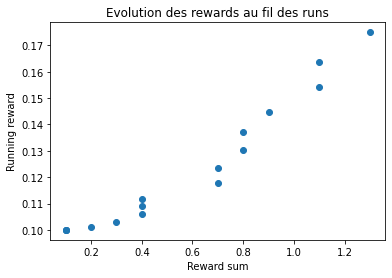

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import json

def show_graph():

    total_reward_sum = []
    total_running_rewards = []

    with open('records/runRewardRecords.json') as json_file:
        file_data = json.load(json_file)
        for elem in file_data['records']:
            total_reward_sum.append(elem['rewardSum'])
            total_running_rewards.append(elem['runningReward'])

    fig, ax = plt.subplots()
    #plt.scatter(total_reward_sum, total_running_rewards, "ko-")
    plt.scatter(total_reward_sum, total_running_rewards, ls="-")
    ax.set_title('Evolution des rewards au fil des runs')
    ax.set_xlabel('Reward sum')
    ax.set_ylabel('Running reward')
    plt.show()
    
show_graph()

In [ ]:
env = retro.make(game="Celeste-GBA", use_restricted_actions=retro.Actions.MULTI_DISCRETE)
observation = env.reset()
prev_x = None  # used in computing the difference frame
xs, hs1, hs2, hs3, dlogps1, dlogps2, dlogps3, drs = [], [], [], [], [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 0
actionIndex = 0.0
t0 = time.time()
while True:
    if render: env.render()

    actionIndex += 0.01

    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    aprob1, h1 = policy_forward(x)
    aprob2, h2 = policy_forward(x)
    aprob3, h3 = policy_forward(x)

    # record various intermediates (needed later for backprop)
    xs.append(x)  # observation
    hs1.append(h1)  # hidden state
    hs2.append(h2)  # hidden state
    hs3.append(h3)  # hidden state
    
    # Action choice with ranges

    # elem1 = 0
    # if aprob1 <= 0.49:
    #     elem1 = 0
    # elif aprob1 <= 0.50:
    #     elem1 = 1
    # else:
    #     elem1 = 2

        
    # elem2 = 0
    # if aprob2 <= 0.49:
    #     elem2 = 0
    # elif aprob2 <= 0.50:
    #     elem2 = 1
    # else:
    #     elem2 = 2

    # elem3 = 0
    # if aprob3 <= 0.485:
    #     elem3 = 0
    # elif aprob3 <= 0.495:
    #     elem3 = 1
    # elif aprob3 <= 0.505:
    #     elem3 = 2
    # else:
    #     elem3 = 4


    # Action choice
    elem1 = 1 if np.random.uniform() < aprob1 else 2
    elem2 = 1 if np.random.uniform() < aprob2 else 2
    elem31 = 1 if np.random.uniform() < aprob3 else 0
    elem32 = 2 if np.random.uniform() < aprob3 else 0

    if elem31 != 0 and elem32 != 0:
        elem3 = 4
    elif elem31 == 1:
        elem3 = 1
    elif elem32 == 2:
        elem3 = 2 
    else:
        elem3 = 0

    # Fake labe http://cs231n.github.io/neural-networks-2/#losses
    dlogps1.append(elem1 - aprob1)
    dlogps2.append(elem2 - aprob2)
    dlogps3.append(elem3 - aprob3)

    # Action
    a = [elem1, elem2, elem3, 0]

    # step the environment and get new measurements
    observation, reward, done, info = env.step(a)

    drs.append(reward)  # record reward (has to be done after we call step() to get reward for previous action)
    
    if done:  # an episode finished
        t1 = time.time()             
        if t1-t0 > 1:        
            reward_sum += 0.1*((t1-t0)//2)    

        episode_number += 1
        

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph1 = np.vstack(hs1)
        eph2 = np.vstack(hs2)
        eph3 = np.vstack(hs3)
        epdlogp1 = np.vstack(dlogps1)
        epdlogp2 = np.vstack(dlogps2)
        epdlogp3 = np.vstack(dlogps3)
        epr = np.vstack(drs)
        xs, hs1, hs2, hs3, dlogps1, dlogps2, dlogps3, drs = [], [], [], [], [], [], [], []  # reset array memory

        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards pong to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp1 *= discounted_epr  # modulate the gradient with advantage (PG magic happens right here.)
        epdlogp2 *= discounted_epr  # modulate the gradient with advantage (PG magic happens right here.)
        epdlogp3 *= discounted_epr  # modulate the gradient with advantage (PG magic happens right here.)
        grad1 = policy_backward(eph1, epdlogp1)
        grad2 = policy_backward(eph2, epdlogp2)
        grad3 = policy_backward(eph3, epdlogp3)
        for k in model: grad_buffer[k] += grad1[k]  # accumulate grad over batch
        for k in model: grad_buffer[k] += grad2[k]  # accumulate grad over batch
        for k in model: grad_buffer[k] += grad3[k]  # accumulate grad over batch

        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k, v in iter(model.items()):
                g = grad_buffer[k]  # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g ** 2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v)  # reset batch gradient buffer

        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward))
        total_reward_sum.append(reward_sum)
        total_running_reward.append(running_reward)

        if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
        reward_sum = 0
        observation = env.reset()  # reset env
        prev_x = None

    if reward != 0:  # Pong has either +1 or -1 reward exactly when game ends.
        print('ep %d: game finished, reward: %f' % (episode_number, reward))
        writeInFile(total_reward_sum, total_running_reward)


<ipython-input-3-707c20f44705>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


resetting env. episode reward total was 0.200000. running mean: 0.200000
ep 1: game finished, reward: -1.000000


<h2> Les inputs </h2>

Sur un simulateur GBA, nous avons 3 types d’inputs pouvant être acceptés:
- Les inputs Discrets où chaque action ou combo correspondent à une touche. Ce type d’input est associé à une chaine de caractères («UP» «DOWN» «LEFT» ...)
- Les inputs MultiDiscrets où chaque action correspond à une touche et un combo à deux touches. Ce type d'input que nous utilisons pour l'IA est associé à un tableau d'entiers et nous y reviendrons juste après.
- Les inputs MultiBinaires où chaque action correspond à une touche et un combo correspond à deux touches bind sur une seule. Ce type d'input est associé à un nombre de 0 à 11 pour le simulateur GBA.

Ici, on utilise les inputs MultiDiscrets et on récupère les résultats de chaque réseau de neurones afin de décider quelle action effectuer. Sous forme MultiDiscret, on doit créer un tableau de 4 éléments (car il y a 4 catégories d'actions sous forme MultiDiscret) et où on place chaque type d'action dans une case.
Par exemple, pour le choix entre la droite et la gauche, on récupère la valeur calculée par le réseau de neurones associé et on le compare avec un nombre aléatoire choisi uniformément, puis en fonction du résultat, on décide d'aller à droite ou à gauche. L'axe horizontal correspond à la première catégorie d'actions donc on met ce résultat dans la première case du tableau.

On remarque qu'on n'utilise pas l'action `Select`, `L` et `R` pour l'IA donc on ignore ces éléments.

On peut également choisir les actions par plage de probabilité comme sur le code en commentaire. 
Cependant, il faut faire une analyse précise des plages à sélectionner pour avoir un agent convenable.

<img src="img/inputs.PNG" />

<h2> RMSProp </h2>

Ce code utilise l’algorithme Root Mean Square Propagation (RMSProp) comme fonction d’optimisation de la descente de gradient stochastique. 
Sa formule est la suivante : $v(w,t) = yv(w,t -1) + 1 (1 - y)(\nabla Q_1(w))^2$

- $\lambda$: decay rate
- $\nabla Q_1(w)$: gradient buffer du batch
- $v(w,t -1)$: La mémoire rmsprop du batch

Et la fonction de la mise à jour des paramètres dans cet algorithme est: $w = \frac{\eta}{\sqrt{(w, t)}} \nabla Q_i(w)$

- $\eta$: learning rate
- $\nabla Q_1(w)$: dragient buffer du batch
- $w$: la pondération d'un neurone

L’algorithme permet donc de converger plus rapidement en diminuant les oscillations grâce à une bonne adaptation du learning rate. Cet algorithme est appliqué tous les 10 épisodes (le batch size). 

<img src="img/rmsprop.PNG" />